# Projet IA - Modèle d'Ising 2D - 2023/2024
Sorbonne Université - Master 1 - Physique Fondamentale et Applications

Guilherme Carvalho - Anatole Cremel-Schlemer - Panet Mathis

## Introduction - Code necessaire

In [1]:
# Importation des librairies
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall, Accuracy, AUC
from tensorflow.keras.utils import plot_model
from numba import njit, prange

# Dossier de travail
#file_dir = "./data/"
file_dir = "./data/"

2023-12-20 10:39:40.122233: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-20 10:39:40.122256: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-20 10:39:40.122263: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-20 10:39:40.239863: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Importation des données fournis
def read_t(t,root="./", str_check=False):
  if not str_check :
    data = pickle.load(open(root+'Ising2DFM_reSample_L40_T=%.2f.pkl'%t,'rb'))
  else :
    data = pickle.load(open(root+f'Ising2DFM_reSample_L40_T={t}.pkl','rb'))
  return np.unpackbits(data).astype(int).reshape(-1,1600)

data_all = read_t("All", file_dir, True)
data_label = pickle.load(open(file_dir+f'Ising2DFM_reSample_L40_T=All_labels.pkl','rb'))
print("Données importées")

Données importées


## Partie 1 : Génération de données

Nous allons voir dans cette partie comment générer des données avec le modèle d'Ising sans passer par l'algorithme de Metropolis. Un code C++ est aussi codé et accéléré mais il y a des petits bug sur l'enregistrement des données au niveau des bords. Le code est disponible sur le github.

### Génération python accéléré

La simulation est accélérée avec numba

#### Fonctions

In [3]:
@njit
def generer_tableau(ratio, size):
    nb = int(size * size * ratio)
    a = np.zeros(size * size)
    arr = np.arange(size * size)
    np.random.shuffle(arr)
    a[arr[:nb]] = 1
    return a.reshape((size, size))


@njit
def calcul_DE(tableau, x, y, size):
    if x == 0 or x == size - 1 or y == 0 or y == size - 1:
        extended_tab = np.zeros((size + 2, size + 2))
        extended_tab[1:size + 1, 1:size + 1] = tableau
        extended_tab[0, 1:size + 1] = tableau[-1]
        extended_tab[-1, 1:size + 1] = tableau[0]
        extended_tab[1:size + 1, 0] = tableau[:, size - 1]
        extended_tab[1:size + 1, size + 1] = tableau[:, 0]
        table_locale = extended_tab[x:x + 3, y:y + 3]
        o = table_locale[1, 1] * 2 - 1
        a = table_locale[0, 1] * 2 - 1
        b = table_locale[1, 0] * 2 - 1
        c = table_locale[1, 2] * 2 - 1
        d = table_locale[2, 1] * 2 - 1
    else:
        table_locale = tableau[x - 1:x + 2, y - 1:y + 2]
        o = table_locale[1, 1] * 2 - 1
        a = table_locale[0, 1] * 2 - 1
        b = table_locale[1, 0] * 2 - 1
        c = table_locale[1, 2] * 2 - 1
        d = table_locale[2, 1] * 2 - 1
    return 2 * o * (a + b + c + d)


@njit
def new_point_parallel(tableau, size, exp_values, nb_pas):
    for _ in prange(size * size * nb_pas):
        coordx = np.random.randint(size)
        coordy = np.random.randint(size)
        DE = calcul_DE(tableau, coordx, coordy, size)
        if test_precomputed(DE, exp_values):
            tableau[coordx, coordy] = not tableau[coordx, coordy]
    return tableau


@njit
def precomputed_exp_values(T):
    return np.array([np.exp(-4 / T), np.exp(-8 / T)])


@njit
def test_precomputed(DE, exp_values):
    if DE == 0 or DE == -4 or DE == -8:
        return True
    if DE == 4 or DE == 8:
        x = np.random.rand()
        return x < exp_values[int(DE / 4 - 1)]
    else:
        print("erreur, DE = ", DE)
        return False


@njit
def M(tableau, size):
    totplus = np.sum(tableau)

    return abs(-1 * (size * size - totplus) + totplus) / (size * size)

#### Génération

16it [00:53,  3.37s/it]


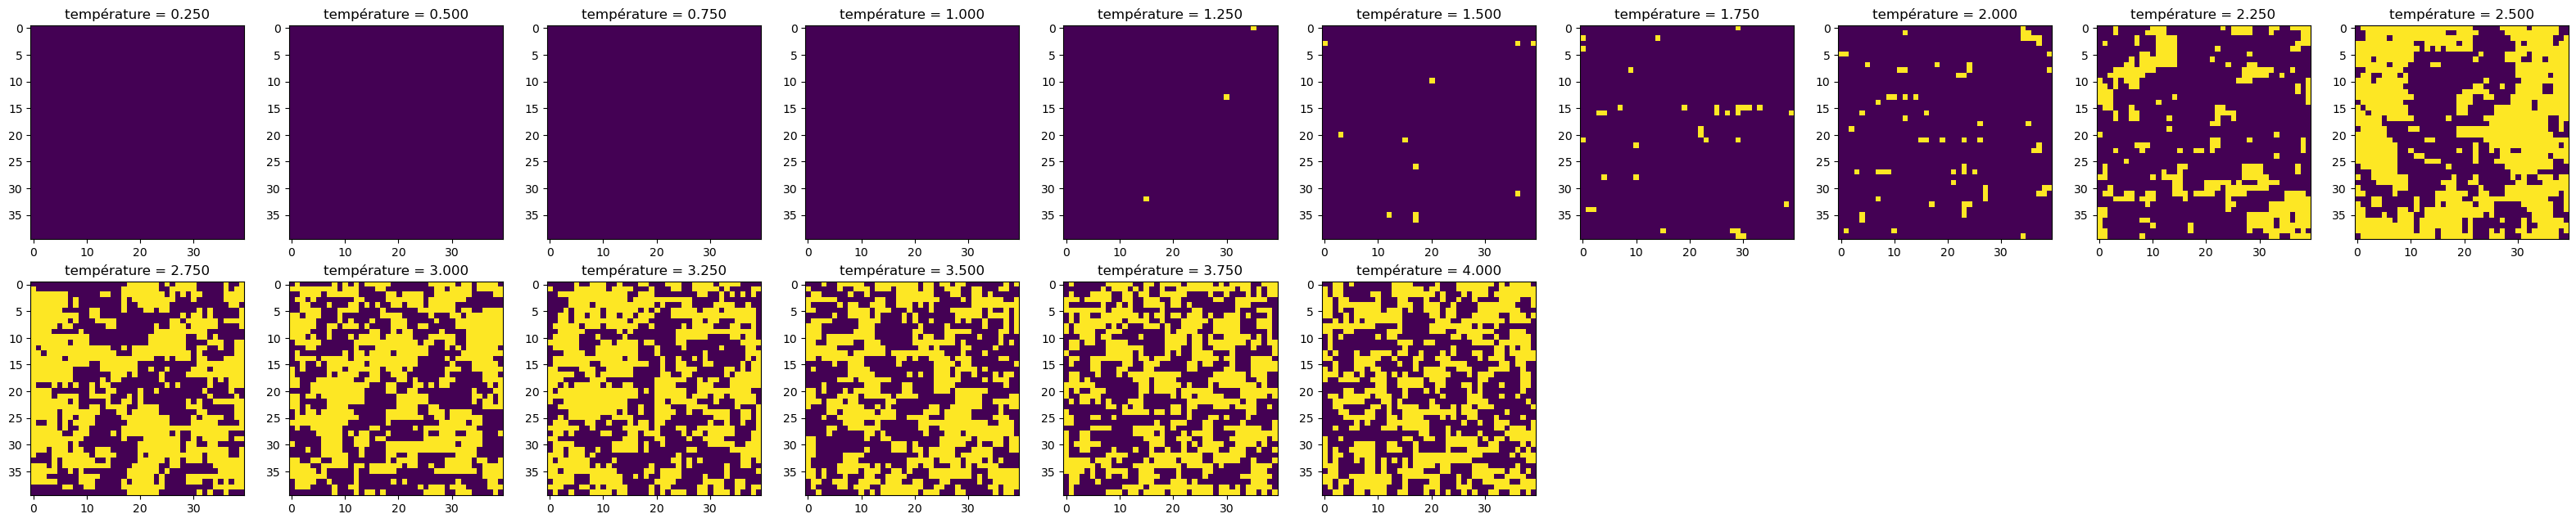

In [4]:
ratio_cases = 0.25

size = 40

tab = generer_tableau(ratio_cases, size)

nb_pas = 300 # un pas correspond à size * size tentatives d'ajouts de nouveaux points
nb_data = 50

T_liste = np.linspace(0.25, 4,16)


Mliste=[]
plt.figure(figsize=[40,40])

for i,T in tqdm(enumerate(T_liste)):
    exp_values = precomputed_exp_values(T)
    for dat in range(nb_data):
        tab = generer_tableau(ratio_cases, size)
        tab = new_point_parallel(tab, size, exp_values,nb_pas)
        Mliste.append(np.sum(tab))
    plt.subplot(10,10,i+1)
    plt.imshow(tab)
    plt.title('température = {:.3f}'.format(T))

plt.show()

#### plot

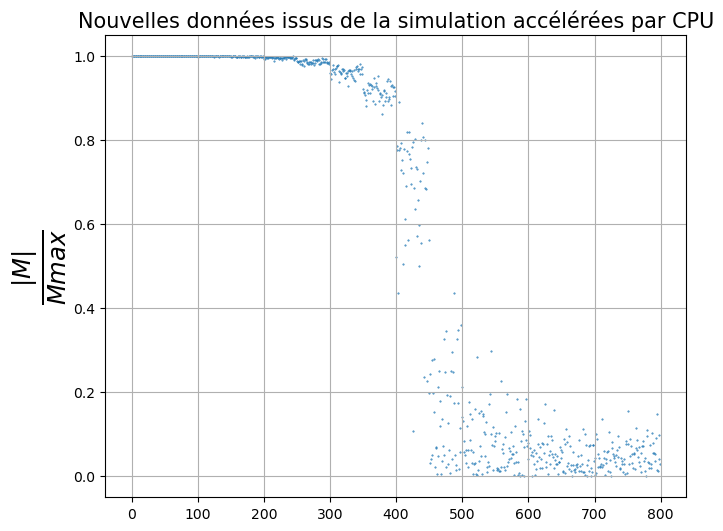

In [5]:
Mliste = (np.abs(np.array(Mliste)-800)*2)/1600

plt.figure(figsize=[7.5,6])
plt.scatter(np.arange(len(Mliste)),Mliste,s=0.2)
plt.ylabel(r'$\frac{|M|}{Mmax}$',size = 25)
plt.grid()
plt.title("Nouvelles données issus de la simulation accélérées par CPU",size = 15)
plt.show()

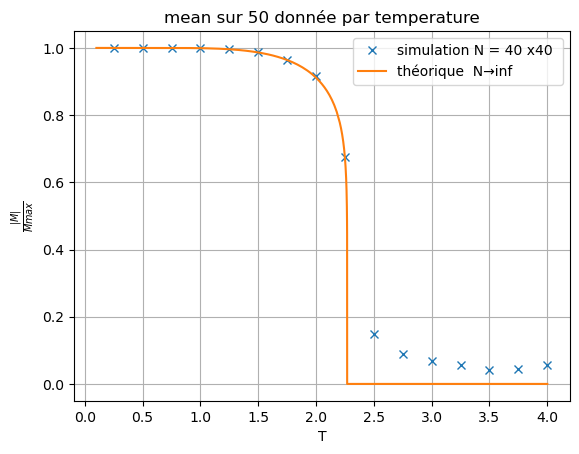

In [6]:
plt.plot(T_liste,Mliste.reshape(len(T_liste),nb_data).mean(axis=1),'x',label = "simulation N = 40 x40 ")

T = np.concatenate((np.linspace(0.1,2.2,100),np.linspace(2.2,2.26918478,100)))
x = (1-1/(np.sinh(2/T))**4)**(1/8)
plt.plot(list(T)+[2.269,3,3.5,3.7,4],list(x)+[0,0,0,0,0],label ="théorique  N→inf")


plt.xlabel('T')
plt.ylabel(r'$\frac{|M|}{Mmax}$')
plt.legend()
plt.grid()
plt.title('mean sur {} donnée par temperature'.format(nb_data))
plt.show()

### Resultats et Comparaison avec donnée du dataset

In [7]:
# Symétrisation des données (cf. Partie 2)

nom_temp = np.arange(0.25, 4.25, 0.25)

tot_data = np.empty((0,40,40))
tot_label = np.empty(0)

for T in nom_temp :
  tmp = read_t(T, file_dir)
  tot_data = np.concatenate((tot_data, tmp.reshape(tmp.shape[0], 40, 40)))
  tot_label = np.concatenate((tot_label, T*np.ones(tmp.shape[0])))

tot_data_sym = 2*np.abs(tot_data.reshape(tot_data.shape[0], 40*40).mean(axis=1) - 0.5)

In [8]:
# Importation des données générées

new_data = np.load("./new_data_accelerated.npy")
new_data.shape

(16000,)

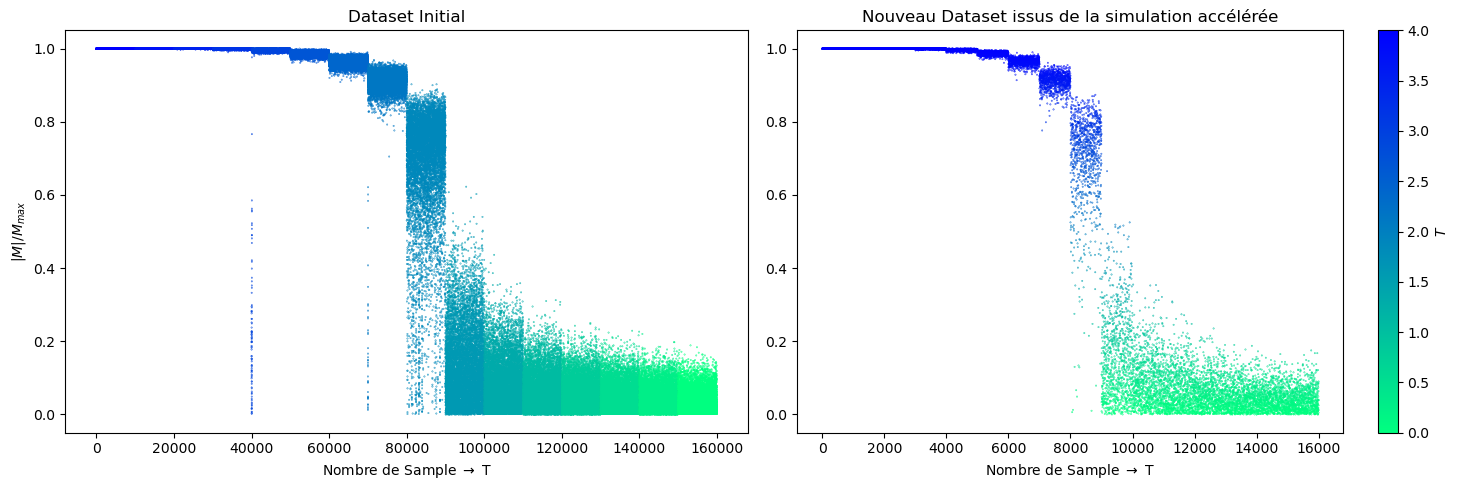

In [9]:
# Figure 1.6

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

cmap = mpl.colormaps['winter']
axs[0].scatter(range(tot_data_sym.shape[0]), tot_data_sym, c=tot_label, cmap=cmap, s=0.1)
axs[0].set_ylabel(r'$|M|/M_{max}$')
axs[0].set_xlabel(r'Nombre de Sample $\rightarrow$ T')
axs[0].set_title(r'Dataset Initial')

cmap = mpl.colormaps['winter_r']
axs[1].scatter(range(new_data.shape[0]), new_data, c=new_data, cmap=cmap, s=0.1)
axs[1].set_xlabel(r'Nombre de Sample $\rightarrow$ T')
axs[1].set_title(r'Nouveau Dataset issus de la simulation accélérée')

plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=4), cmap=cmap), ax=axs[1], label=r'$T$')
plt.tight_layout()
plt.show()

## Partie 2 : Pré-traitement des données

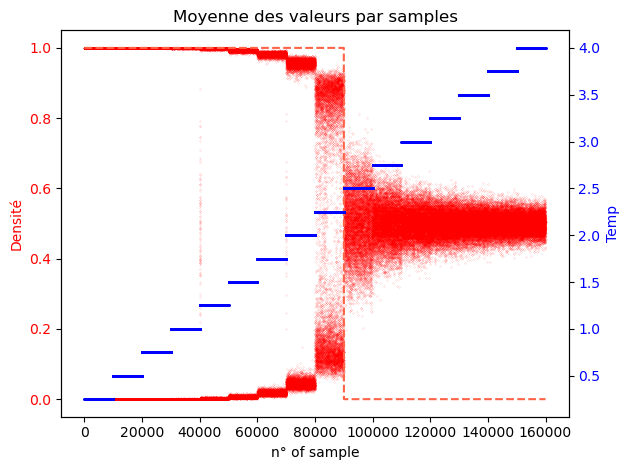

In [10]:
# Figure 2.1a
fig, ax1 = plt.subplots()

ax1.set_xlabel('n° of sample')
ax1.set_ylabel('Densité', color="red")
ax1.scatter(range(160000), tot_data.reshape(tot_data.shape[0], 40*40).mean(axis=1), s=.005, label="Mean value of samples", c="r")
ax1.plot(range(160000), data_label, "--", label="Labels", c='tomato')
ax1.tick_params(axis='y', labelcolor="r")

ax2 = ax1.twinx()

ax2.set_ylabel('Temp', color="b")
ax2.scatter(range(160000), tot_label, s=.1, label="Temps", c="b")
ax2.tick_params(axis='y', labelcolor="b")

ax1.set_title("Moyenne des valeurs par samples")

fig.tight_layout()
plt.show()

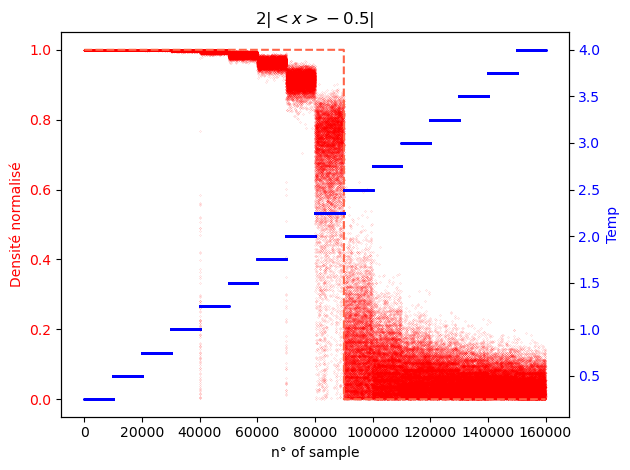

In [11]:
# Figure 2.1b
fig, ax1 = plt.subplots()

ax1.set_xlabel('n° of sample')
ax1.set_ylabel('Densité normalisé', color="red")
ax1.scatter(range(160000), tot_data_sym, s=.005, label="Mean value of samples", c="r")
ax1.plot(range(160000), data_label, "--", label="Labels", c='tomato')
ax1.tick_params(axis='y', labelcolor="r")

ax2 = ax1.twinx()

ax2.set_ylabel('Temp', color="b")
ax2.scatter(range(160000), tot_label, s=.1, label="Temps", c="b")
ax2.tick_params(axis='y', labelcolor="b")

ax1.set_title(r'$2 |<x> - 0.5|$')

fig.tight_layout()
plt.show()

## Partie 3 : Modèles classiques

### 3.1 Analyse par la magnétisation

In [12]:
# Modèle naif
mean_temperature = np.mean(tot_label)
predictions = np.full_like(tot_label, mean_temperature)

# Calcul de la MSE
mse = mean_squared_error(tot_label, predictions)
print("MSE:", mse)

MSE: 1.328125


In [13]:
# Model linéaire sur les spins 
tot_data_sym_dim = np.c_[tot_data_sym.reshape(-1, 1), (tot_data_sym.reshape(-1, 1))**2, (tot_data_sym.reshape(-1, 1))**3, (tot_data_sym.reshape(-1, 1))**4]
X_train, X_test, y_train, y_test = train_test_split(tot_data_sym_dim, tot_label, test_size=0.2, random_state=42)
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
predictions = linear_model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
print("MSE :", mse)

MSE : 0.15078828385391982


In [14]:
# Modèle de Forêt Aléatoire
T_C = 2.269

# Séparer les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(tot_data_sym.reshape(-1,1), tot_label, test_size=0.2, random_state=42)

# Créer le modèle de régression de forêt aléatoire
forest_model = RandomForestRegressor(max_depth=5, bootstrap=True, n_estimators=100)

# Adapter le modèle aux données d'entraînement
forest_model.fit(X_train, y_train)

# Prédire sur les données de test
predictions = forest_model.predict(X_test)

# Classe réelle
real_class = np.where(y_test>T_C, 1, 0)

# Classe prédite
pred_class = np.where(predictions>T_C, 1, 0)

# Calculer l'erreur quadratique moyenne
mse = mean_squared_error(y_test, predictions)
print("mse:", mse)

kde_data = pd.DataFrame({'T':tot_label, 'Sym':tot_data_sym})
xnew = np.linspace(0, 1, 100)
ynew = forest_model.predict(xnew.reshape(-1, 1))

mse: 0.10821281920094998


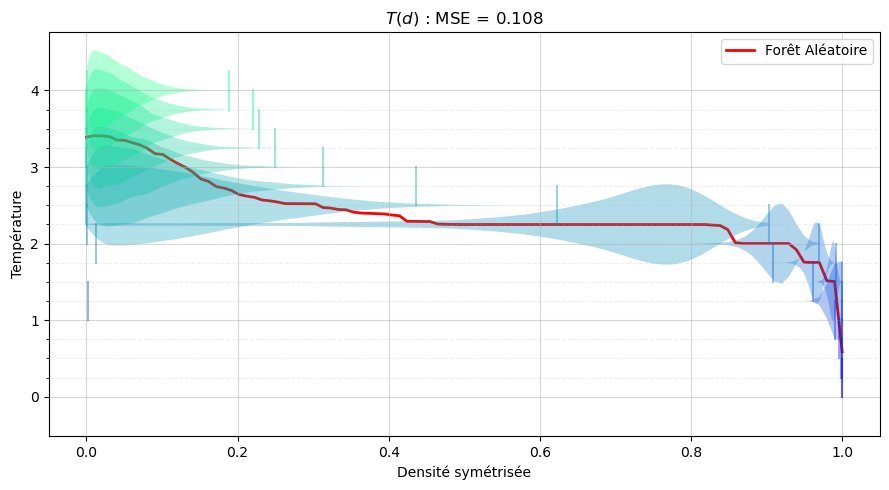

In [15]:
# Figure 3.1a
fig, ax = plt.subplots(figsize=(9, 5))
cmap = plt.get_cmap('winter', 16)

violinplots = []

for i in range(16):
    violinplot = ax.violinplot(
        kde_data[kde_data['T'] == nom_temp[i]]['Sym'],
        positions=[nom_temp[i]],
        showmeans=False,
        showextrema=True,
        widths=1.05,
        vert=False,
    )
    # Changer les couleurs en utilisant cmap
    violinplot['cmaxes'].set_color(cmap(i))
    violinplot['cmins'].set_color(cmap(i))
    violinplot['cbars'].set_color(cmap(i))
    for pc in violinplot['bodies']:
        pc.set_facecolor(cmap(i))
    # Changer l'épaisseur de ligne et l'opacité de la ligne
    violinplot['cmaxes'].set_alpha(0.4)
    violinplot['cmins'].set_alpha(0.4)
    violinplot['cbars'].set_alpha(0)
    
    violinplots.append(violinplot)

# Ajouter la ligne de la forêt aléatoire
ax.plot(xnew, ynew, color='r', linewidth=2, zorder=0, label="Forêt Aléatoire")

# Créer la légende
ax.legend()

# Ajouter des ticks mineurs à l'axe y
ax.set_yticks(nom_temp, minor=True)

ax.set_xlabel("Densité symétrisée")
ax.set_ylabel("Température")
ax.set_title(f"$T(d)$ : MSE = {mse:.3f}")

# Ajouter une grille aux ticks majeurs et mineurs
ax.grid(which='major', alpha=0.5, zorder=-1)
ax.grid(which='minor', alpha=0.2, linestyle='--', zorder=-1)

plt.tight_layout()
plt.show()

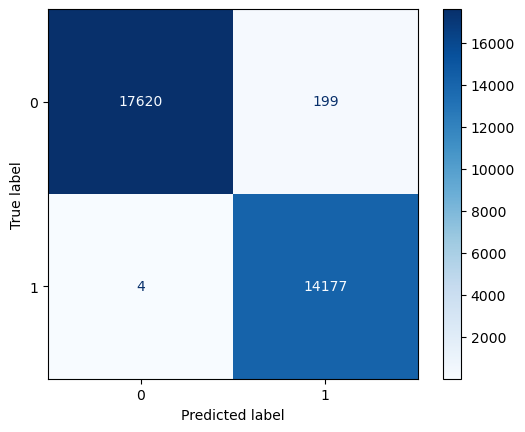

In [16]:
# Figure 3.1b
conf_mat = confusion_matrix(real_class, pred_class)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
disp.plot(cmap='Blues')
plt.show()

### 3.2 : Analyse par les spins

In [17]:
# Modele naif

percentage_class_1 = data_label[data_label == 1].shape[0] / data_label.shape[0]
print(f"Pourcentage de classe 1 : {percentage_class_1*100:.2f}%")
percentage_class_0 = data_label[data_label == 0].shape[0] / data_label.shape[0]
print(f"Pourcentage de classe 0 : {percentage_class_0*100:.2f}%")

# Create a naive model
def naive_model():
    if np.random.uniform() < percentage_class_1:
        return 1
    else:
        return 0

# Test the naive model
predictions = [naive_model() for _ in range(data_label.shape[0])]

print("MSE:", mean_squared_error(data_label, predictions))
print("Accuracy:", np.mean(data_label == predictions))

Pourcentage de classe 1 : 56.25%
Pourcentage de classe 0 : 43.75%
MSE: 0.4930375
Accuracy: 0.5069625


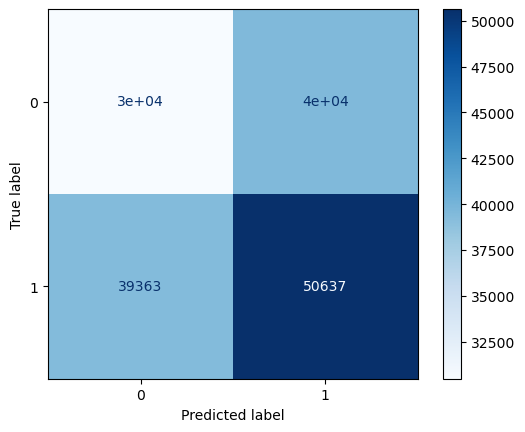

In [18]:
conf_mat = confusion_matrix(data_label, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
disp.plot(cmap='Blues')
plt.show()

## Partie 4 : Réseaux de neurones

In [19]:
# Creation des données pour le modèle de CNN
mean_val = tot_data.reshape(tot_data.shape[0], 40*40).mean(axis=1)
tot_data = tot_data.astype(np.uint8)

tot_data[mean_val > 0.5] = np.invert(tot_data[mean_val > 0.5])//255

In [38]:
# Création du modèle de CNN
tot_data_cnn = tot_data.reshape(tot_data.shape[0], 40, 40, 1)

X_train, X_test, y_train, y_test = train_test_split(tot_data_cnn, data_label, test_size=0.2, random_state=42)

model = Sequential()
model.add(Conv2D(16, (5, 5), input_shape=(40, 40, 1), padding='same', activation='relu'))
model.add(MaxPooling2D(2))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(2))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2))
model.add(Flatten())
model.add(Dense(128))
model.add(Dense(64))
model.add(Dense(128))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mse', 'accuracy', Precision(), Recall(), AUC()])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 40, 40, 16)        416       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 20, 20, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 18, 18, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 9, 9, 32)          0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 7, 7, 64)          18496     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 3, 3, 64)         

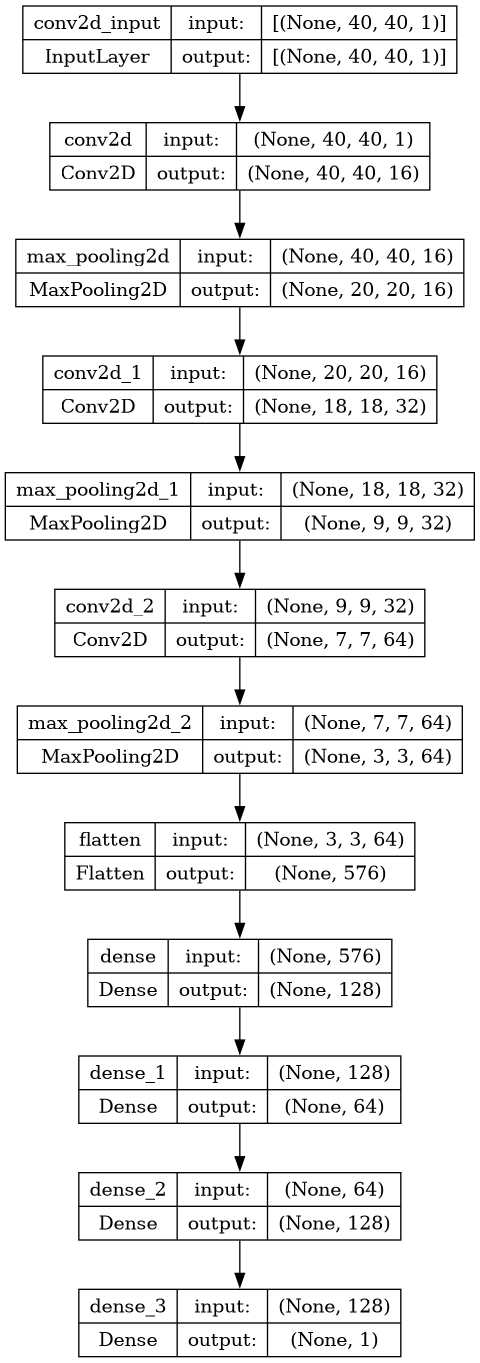

In [21]:
# Figure 4.1
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [39]:
# Entraînement du modèle de CNN
callback = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=30, batch_size=128, validation_split=0.2, callbacks = [callback])

Epoch 1/30
800/800 [==============================] - 4s 4ms/step - loss: 0.0201 - mse: 0.0054 - accuracy: 0.9933 - precision_3: 0.9971 - recall_3: 0.9910 - auc_3: 0.9994 - val_loss: 0.0057 - val_mse: 0.0015 - val_accuracy: 0.9982 - val_precision_3: 0.9997 - val_recall_3: 0.9971 - val_auc_3: 0.9999
Epoch 2/30
800/800 [==============================] - 3s 4ms/step - loss: 0.0069 - mse: 0.0018 - accuracy: 0.9977 - precision_3: 0.9985 - recall_3: 0.9975 - auc_3: 0.9999 - val_loss: 0.0065 - val_mse: 0.0018 - val_accuracy: 0.9977 - val_precision_3: 1.0000 - val_recall_3: 0.9960 - val_auc_3: 0.9999
Epoch 3/30
800/800 [==============================] - 3s 4ms/step - loss: 0.0064 - mse: 0.0017 - accuracy: 0.9979 - precision_3: 0.9985 - recall_3: 0.9977 - auc_3: 0.9999 - val_loss: 0.0078 - val_mse: 0.0019 - val_accuracy: 0.9976 - val_precision_3: 1.0000 - val_recall_3: 0.9958 - val_auc_3: 0.9996
Epoch 4/30
800/800 [==============================] - 3s 4ms/step - loss: 0.0058 - mse: 0.0016 - acc

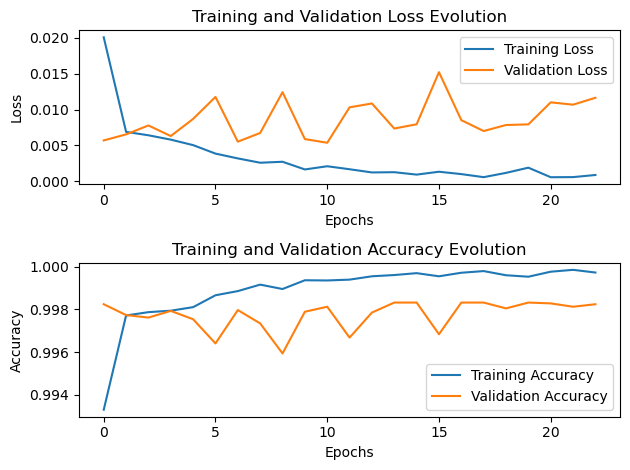

In [40]:
# Figure 4.2
plt.subplot(211)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Evolution')

plt.subplot(212)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy Evolution')

plt.tight_layout()
plt.show()

In [41]:
# Affichage des métriques
test_loss, test_mse, test_accuracy, test_precision, test_recall, test_auc = model.evaluate(X_test, y_test)
print('test loss', test_loss)
print('test mse', test_mse)
print('test accuracy', test_accuracy)
print('test precision', test_precision)
print('test recall', test_recall)
print('test auc', test_auc)

1000/1000 [==============================] - 2s 1ms/step - loss: 0.0064 - mse: 0.0017 - accuracy: 0.9979 - precision_3: 0.9974 - recall_3: 0.9988 - auc_3: 0.9999
test loss 0.00636126846075058
test mse 0.0017412687884643674
test accuracy 0.9979062676429749
test precision 0.9974220991134644
test recall 0.998821496963501
test auc 0.999942421913147


1000/1000 [==============================] - 1s 755us/step


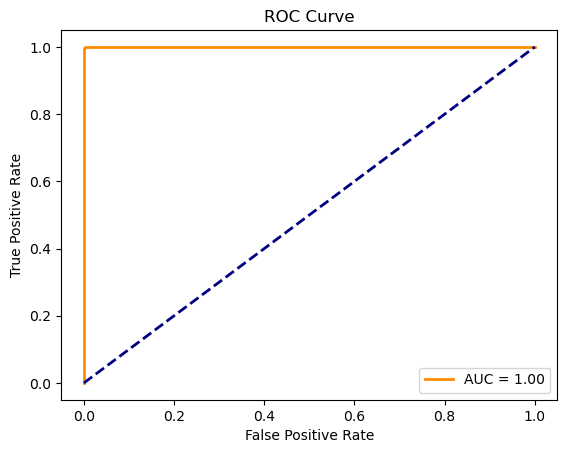

In [42]:
# Figure 4.4
y_pred = model.predict(X_test)

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

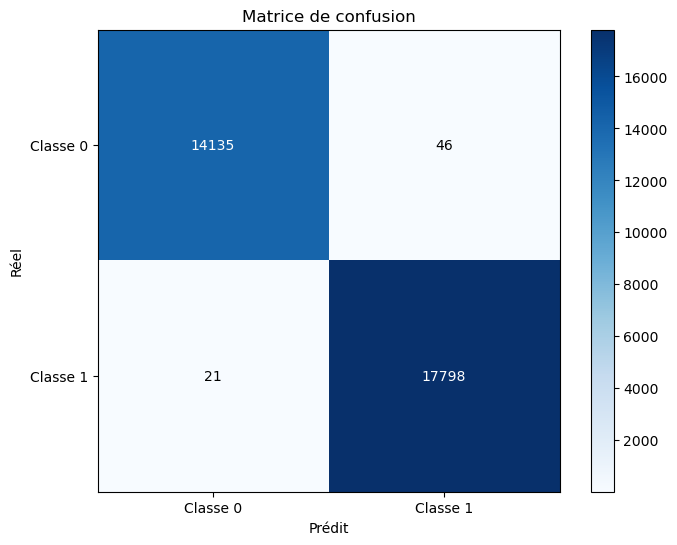

In [43]:
# Figure 4.5
y_pred.reshape(32000,)

y_pred_binary = (y_pred > 0.5).astype(int)
conf_matrix = confusion_matrix(y_test, y_pred_binary)

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matrice de confusion')
plt.colorbar()

classes = ['Classe 0', 'Classe 1']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

plt.xlabel('Prédit')
plt.ylabel('Réel')

for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, str(conf_matrix[i, j]), horizontalalignment='center', verticalalignment='center', color='white' if conf_matrix[i, j] > conf_matrix.max() / 2 else 'black')

plt.show()

## Générateur d'Images

### auto encodeur
Après de très nombreuses architectures et un succès limité et incomplet. Ce code permet d'entrainer un auto-encodeur à générer des images.
Le programme de post processing est pas au top mais je n'ai plus le temps de travailler dessus, sa performance optimum est au alentour de T=2.25

Vous trouverez ici une version partiel du programme.

Il faut aller voir le fichier `Ising-Model_IA_M1/gen_new_method/auto-encoder` pour avoir le programme complet. La simulation étant visiblement assez longue dans le modèle de base (130 epochs pour 16 températures).
Nous avons choisie de nous concentrer sur la température T = 2.25.



Pour voir les resultats du programme normal, il faut aller dans le fichier 
`Ising-Model_IA_M1/gen_new_method/auto-encoder/result`.

Le programme est assez bugé sur la reconstruction d'image et ne génére pas directement une nouvelle images.

Pour cela il faudrait diagonaliser la matrice des vecteurs moyens afin de trouver le vecteur propre associé à une température.
ET ensuite appliquer une matrice de passage pour revenir dans l'espace latent et enfin reconstruire une nouvelle image.

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


#### new dataset

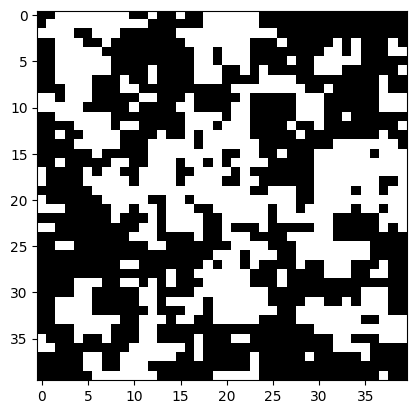

In [213]:
import time

def read_t(t,root="./", str_check=False):
  if not str_check :
    data = pickle.load(open(root+'Ising2DFM_reSample_L40_T=%.2f.pkl'%t,'rb'))
  else :
    data = pickle.load(open(root+f'Ising2DFM_reSample_L40_T={t}.pkl','rb'))
  return np.unpackbits(data).astype(int).reshape(-1,1600)



Data_All = []
Data_Label = []
for T in np.arange(0.25,4.25,0.25):
    data_all = read_t('%.2f'%T, file_dir, True)
    data_all.shape
    
    mean_val = data_all.reshape(data_all.shape[0], 40*40).mean(axis=1)
    data_all = data_all.astype(np.uint8)
    
    data_all[mean_val > 0.5] = np.invert(data_all[mean_val > 0.5])//255
    data_all.shape
    data_label = np.array([T]*data_all.shape[0])
    Data_All.append(data_all)
    Data_Label.append(data_label)
    
Data_All = np.array(Data_All)
Data_Label = np.array(Data_Label)

plt.imshow(Data_All[10][0].reshape(40,40))

(10000, 40, 40, 1)
Epoch 1/60
25/25 [==============================] - 1s 25ms/step - loss: 0.5688 - val_loss: 0.4918
Epoch 2/60
25/25 [==============================] - 0s 12ms/step - loss: 0.4778 - val_loss: 0.4649
Epoch 3/60
25/25 [==============================] - 0s 12ms/step - loss: 0.4620 - val_loss: 0.4529
Epoch 4/60
25/25 [==============================] - 0s 12ms/step - loss: 0.4505 - val_loss: 0.4405
Epoch 5/60
25/25 [==============================] - 0s 12ms/step - loss: 0.4320 - val_loss: 0.4140
Epoch 6/60
25/25 [==============================] - 0s 12ms/step - loss: 0.4105 - val_loss: 0.4019
Epoch 7/60
25/25 [==============================] - 0s 12ms/step - loss: 0.3996 - val_loss: 0.3918
Epoch 8/60
25/25 [==============================] - 0s 12ms/step - loss: 0.3911 - val_loss: 0.3843
Epoch 9/60
25/25 [==============================] - 0s 12ms/step - loss: 0.3842 - val_loss: 0.3776
Epoch 10/60
25/25 [==============================] - 0s 12ms/step - loss: 0.3768 - val_los

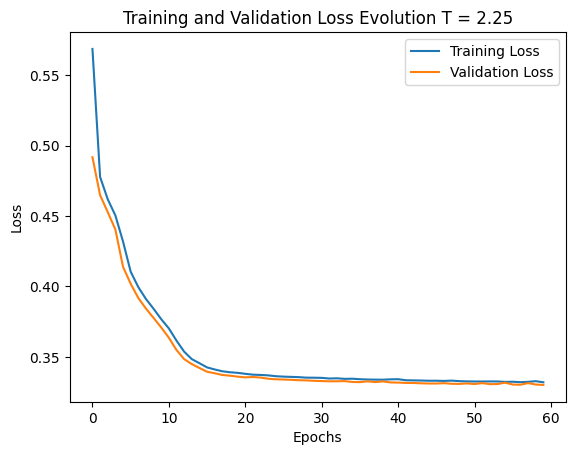

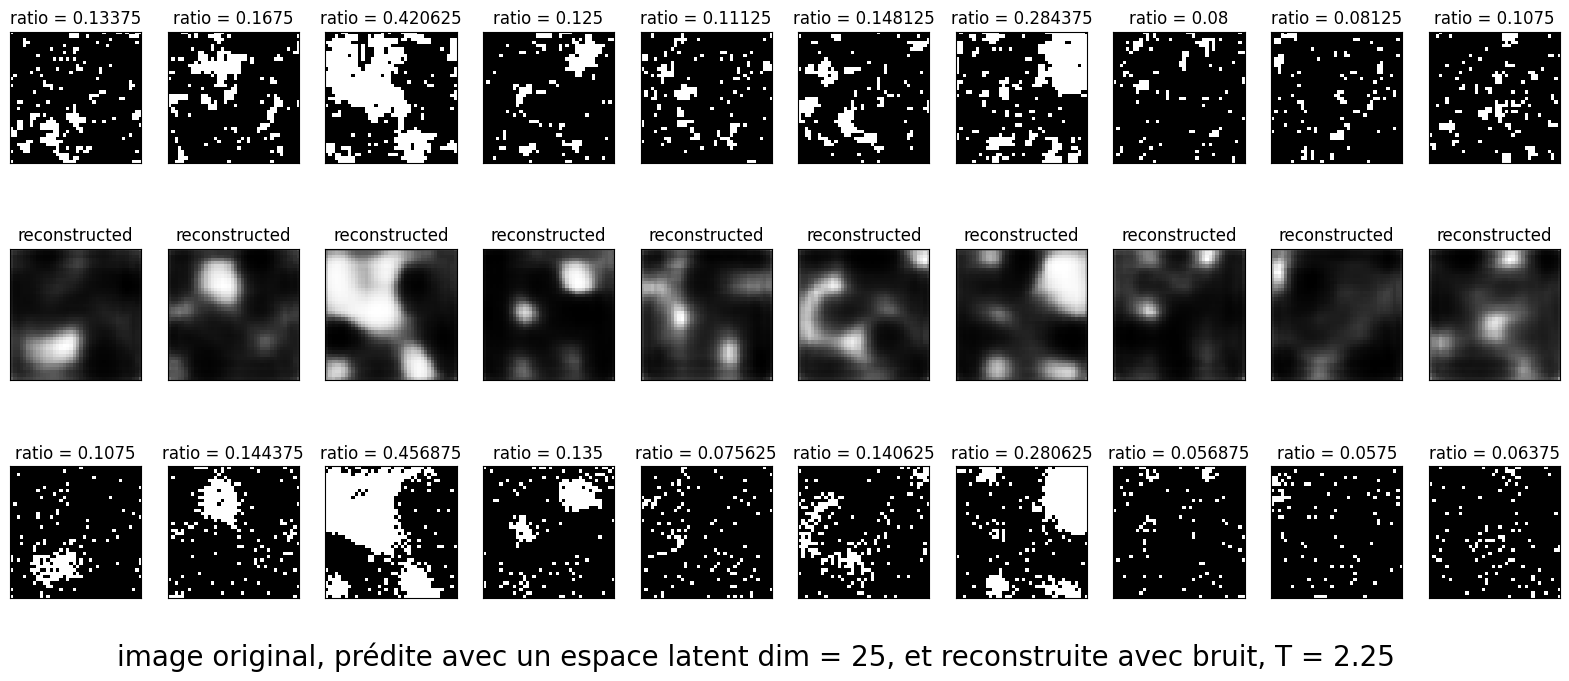

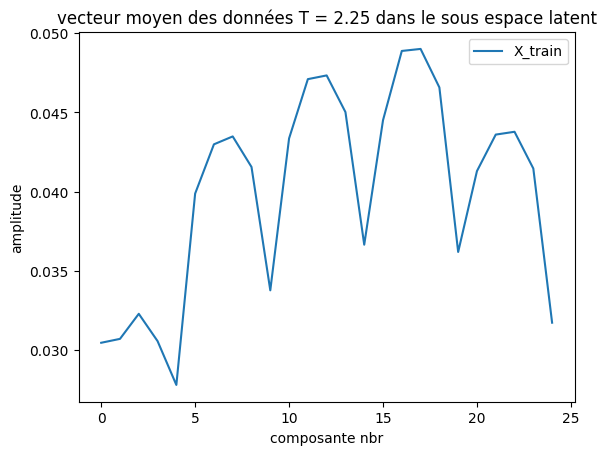

In [216]:
VEC=[]
VEC1=[]
Tliste = np.arange(0.25,4.25,0.25)
#for i in np.flip(np.arange(16)):

for i in [8]:
    time.sleep(1)
     
    
    class Autoencoder(Model):
        def __init__(self):
            super(Autoencoder, self).__init__()
            self.encoder = tf.keras.Sequential([
                
                layers.Input(shape=(40, 40, 1)),
                layers.Conv2D(5, (7, 7), activation='relu', padding='same'),
                layers.Conv2D(5, (3, 3),padding='same', activation='relu'),
                layers.MaxPooling2D(pool_size=(2, 2)),
                layers.Conv2D(5, (3, 3),padding='same', activation='relu'),
                layers.Conv2D(15, (3, 3), activation='relu', padding='same'),
                layers.MaxPooling2D(pool_size=(2, 2)),
                layers.Conv2D(15, (3, 3), activation='relu', padding='same'),
                layers.MaxPooling2D(pool_size=(2, 2)),
                layers.Conv2D(15, (3, 3), activation='relu', padding='same'),
                layers.Conv2D(1, (5, 5), activation='relu', padding='same'),
    
            ])
            
            self.decoder = tf.keras.Sequential([
                layers.Input(shape=(5, 5, 1)),
                layers.UpSampling2D((2,2), interpolation = 'nearest'),
                layers.Conv2D(5, (5, 5),padding='same', activation='relu'),
                layers.UpSampling2D((2,2), interpolation = 'nearest'),
                layers.Conv2D(3, (3, 3),padding='same', activation='relu'),
                layers.UpSampling2D((2,2), interpolation = 'nearest'),
                layers.Conv2D(3, (5, 5),padding='same', activation='relu'),
                layers.Conv2D(1, (3, 3),padding='same', activation='sigmoid'),
    
            ])
        def call(self, x):
            encoded = self.encoder(x)
            decoded = self.decoder(encoded)
            return decoded
    
    autoencoder = Autoencoder()


    # Compile the model
    autoencoder.compile(loss='binary_crossentropy', optimizer='adam')




    
    
    tot_data_cnn = Data_All[i].reshape(Data_All[i].shape[0], 40, 40, 1)
    print(tot_data_cnn.shape)
    X_train, X_test, y_train, y_test = train_test_split(tot_data_cnn, data_label, test_size=0.2, random_state=42)
    history = autoencoder.fit(X_train, X_train, epochs=60, batch_size=264,
                  validation_split=0.2)
    encoded_imgs = autoencoder.encoder(X_test).numpy()
    decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()
    #plt.imshow(decoded_imgs[0].reshape(40,40))
    plt.show()
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss Evolution T = {}'.format(Tliste[i]))
    plt.savefig('D:/ising/evoltution T = {} .jpg'.format(Tliste[i]),dpi=300)
    plt.show()

    
    n = 10
    T = Tliste[i]
    
    plt.figure(figsize=(20, 8))
    for j in range(n):
        img = np.copy(decoded_imgs[j])
        # display original
        ax = plt.subplot(3, n, j + 1)
        plt.imshow(X_test[j])
        plt.title("ratio = {}".format(np.sum(X_test[j].reshape(1600))/1600))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display reconstruction
        ax = plt.subplot(3, n, j + 1 + n)
        plt.imshow(decoded_imgs[j])
        plt.title("reconstructed")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        ax = plt.subplot(3, n, j + 1 + 2*n)
        img=  1.8*(img.reshape(1600)-0.1) + 1*np.random.normal(-0.1,0.2,1600) + 0.15*np.random.normal(0.2,2,1600) 
        ratio = T/4
        sig = -1/(2+2*np.exp(-(T-2)*4))+1
        img[img<=0.5]=0
        img[img>0.5]=1
        plt.imshow(img.reshape(40,40))
        plt.title("ratio = {}".format(np.sum(img.reshape(1600))/1600))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.text(-400,60,'image original, prédite avec un espace latent dim = 25, et reconstruite avec bruit, T = {}'.format(Tliste[i]),size = 20)
    plt.savefig('D:/ising/triple_T = {} .jpg'.format(Tliste[i]),dpi=300)
    plt.show()
    time.sleep(1)
    
    encoded_imgs1 = autoencoder.encoder(X_train).numpy()
    vec1 = np.sum(encoded_imgs1.reshape(np.shape(encoded_imgs1)[0],25),axis=0)
    VEC1.append(vec1)
    vec = np.sum(encoded_imgs.reshape(np.shape(encoded_imgs)[0],25),axis=0)
    VEC.append(vec)
    if np.sum(vec1)==0:
        plt.plot(range(25),vec1,label='X_train')
    if np.sum(vec)==0:
        plt.plot(range(25),vec,label='X_test')
    elif np.sum(vec1)!=0:  
        plt.plot(range(25),vec1/np.sum(vec1),label='X_train')
    elif np.sum(vec)!=0:  
        plt.plot(range(25),vec/np.sum(vec),label='X_test')
    plt.xlabel('composante nbr')
    plt.ylabel('amplitude')
    plt.legend()
    plt.title('vecteur moyen des données T = {} dans le sous espace latent'.format(Tliste[i]))
    plt.savefig('D:/ising/latent_T = {} .jpg'.format(Tliste[i]),dpi=300)
    plt.show()
    del X_train
    del X_test
    time.sleep(1)